In [1]:
import copy
from functools import reduce
import pandas as pd
from typing import List, Tuple
import pandas as pd
from matplotlib import pyplot as plt
import mpl_finance as mpf

In [2]:
with open('./resources/ticks/last_file.csv', 'r', encoding='utf-8') as f:
    prices = f.readlines()
with open('./resources/ticks/volume.csv', 'r', encoding='utf-8') as f:
    volumes = f.readlines()

In [3]:
def make_linear(lines: List[str]) -> List[float]:
    records = []
    for line in lines:
        records.extend(line.split(','))
    return list(map(lambda x: float(x), filter(lambda y: not str.isspace(y), records)))

In [4]:
def chunk_tick(size: int, records: List[float]) -> List[List[float]]:
    chunks = []
    for i in range(0, len(records), size):
        chunks.append(records[i:i+size])
    return chunks

In [5]:
def chunk_volume(volume: float, records: List[float], volumes: List[float]) -> List[List[float]]:
    chunks = []
    current_chunk = []
    current_volume = 0.0
    volume_counter = copy.deepcopy(volumes)
    i = 0
    while i<len(records):
        current_chunk.append(records[i])
        next_volume = current_volume + volume_counter[i]
        if next_volume>=volume:
            volume_counter[i] = next_volume - volume
            current_volume = 0
            chunks.append(current_chunk)
            current_chunk = []
            if next_volume==volume:
                i+=1
        else:
            current_volume = next_volume
            i+=1
    if len(current_chunk)!=0:
        chunks.append(current_chunk)
    return chunks

In [6]:
def chunk_dollar(dollar: float, records: List[float], volumes: List[float]) -> List[List[float]]:
    dollars = list(map(lambda x: x[0]*x[1], zip(records, volumes)))
    return chunk_volume(dollar, records, dollars)

In [7]:
def show_bar_chart(bar:  List[Tuple[int, float, float, float, float]]):
    dfcvs = pd.DataFrame(bar)
    dfcvs.columns = ['时间','开盘','收盘','最高','最低']
    data_mat=dfcvs.values    
    fig,ax=plt.subplots(figsize=(1200/72,480/72))
    fig.subplots_adjust(bottom=0.1)   
    mpf.candlestick_ohlc(ax=ax,quotes=data_mat,colordown='#53c156', colorup='#ff1717',width=0.3,alpha=1)

In [8]:
def extract_bar_features(raw_bars: List[List[float]]) -> List[Tuple[int, float, float, float, float]]:
    res = []
    for i in range(0,len(raw_bars)):
        raw_bar = raw_bars[i]
        start = raw_bar[0]
        end = raw_bar[-1]
        minv = reduce(min, raw_bar, float('inf'))
        maxv = reduce(max, raw_bar, float('-inf'))
        res.append((i, start, end, maxv, minv))
    return res

In [9]:
linear_prices = make_linear(prices)
linear_volumes = make_linear(volumes)

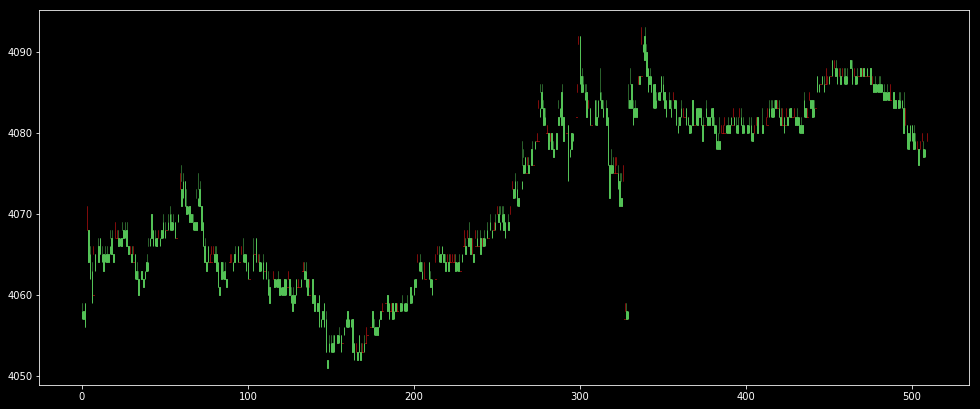

In [10]:
tick_bars = extract_bar_features(chunk_tick(100, linear_prices))
show_bar_chart(tick_bars)

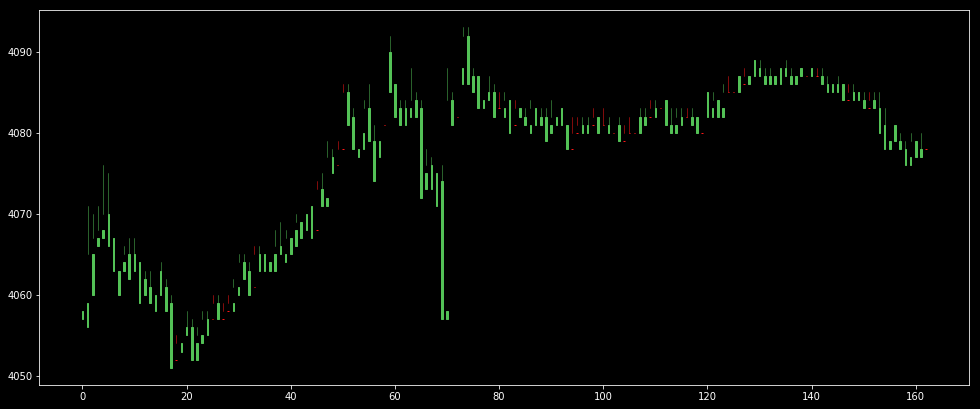

In [11]:
volume_bars = extract_bar_features(chunk_volume(10e7, linear_prices, linear_volumes))
show_bar_chart(volume_bars)

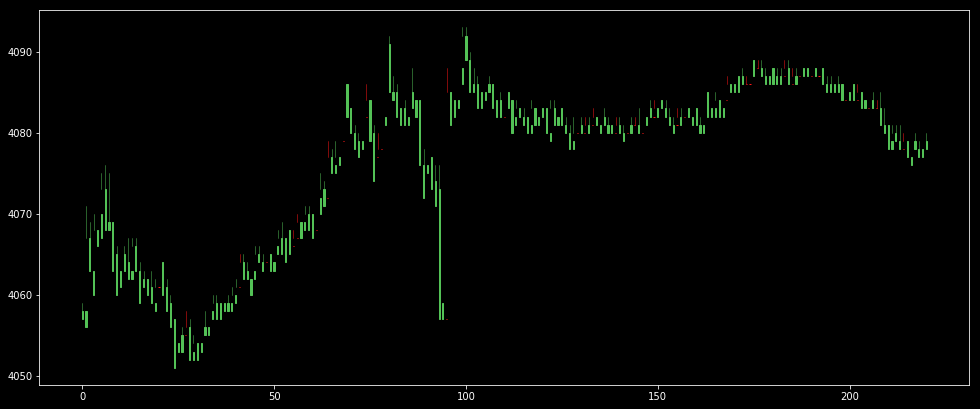

In [12]:
dollar_bars = extract_bar_features(
    chunk_dollar(3 * 10e10, linear_prices, linear_volumes))
show_bar_chart(dollar_bars)